# Using the dataset with minimal dependencies

In this example, we show how to access COP3D images, masks, and metadata in a low-level way, without substantial dependencies.

The dataset provides metadata in two equivalent formats: zipped json files (one set per category) and SQLite database (global). This example uses the former. Sequence-level annotations (such as sequence name and camera pose estimation quality) are stored in `cat/sequence_annotations.jgz` and `dog/sequence_annotations.jgz` files, and frame-level annotations (such as timestamps and relative image paths) are stored in the corresponding `frame_annotations.jgz` files.

The function `show_category` below demonstrates how to:
* load the annotations from JSON files using the functions from CO3D tools in a type-safe manner (i.e. return lists of FrameAnnotation and SequenceAnnotation objects rather than raw dicts);
* join sequence annotations to frame annotations to group frames by sequence and plot the distribution of sequence lengths,
* load some of the images and foreground masks from one sequence to numpy arrays, and display the masked images with corresponding timestamps;
* uses estimated camera pose to plot the camera trajectory projection to the horizontal plane.

In [1]:
import os
from typing import List

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
from co3d.dataset.data_types import (
    load_dataclass_jgzip,
    FrameAnnotation,
    SequenceAnnotation,
)

**Replace `<ROOT>` below with your download location!**

In [3]:
DATASET_ROOT = "<ROOT>"

In [4]:
def get_camera_center_world(viewpoint):
    # center = -inv(R) @ T; R is orthogonal
    return -np.array(viewpoint.R).T @ np.array(viewpoint.T)[:, None]

def show_category(category, n_vis_frames=20, n_image_cols=5):
    fa_file = os.path.join(DATASET_ROOT, category, "frame_annotations.jgz")
    sa_file = os.path.join(DATASET_ROOT, category, "sequence_annotations.jgz")
    
    frame_annos = load_dataclass_jgzip(fa_file, List[FrameAnnotation])
    sequence_annos = load_dataclass_jgzip(sa_file, List[SequenceAnnotation])
    
    print("Number of sequences:", len(sequence_annos))
    frames_by_seq = {seq.sequence_name: [] for seq in sequence_annos}
    for frame in frame_annos:
        assert frame.sequence_name in frames_by_seq
        frames_by_seq[frame.sequence_name].append(frame)
        
    seq_lengths = [len(frames) for frames in frames_by_seq.values()]
    plt.figure()
    plt.hist(seq_lengths)
    plt.xlabel("num frames")
    plt.ylabel("num sequences")
    plt.title("Distribution of sequence lengths")

    seq_name, frames = next(iter(frames_by_seq.items()))
    interval = len(frames) // n_vis_frames
    subsampled_frames = frames[::interval]
    images = [
        np.array(Image.open(os.path.join(DATASET_ROOT, frame.image.path)).convert("RGB"), dtype=float) / 255.0
        for frame in subsampled_frames
    ]
    masks = [
        np.array(Image.open(os.path.join(DATASET_ROOT, frame.mask.path)), dtype=float) / 255.0
        for frame in subsampled_frames
    ]
    timestamps = [frame.frame_timestamp for frame in subsampled_frames]
    print("Showing sequence", seq_name)
    ax = plt.figure(figsize=(20, 12)).subplots(-(-n_vis_frames // n_image_cols), n_image_cols).reshape(-1)
    for slot in ax:
        slot.get_xaxis().set_visible(False)
        slot.get_yaxis().set_visible(False)
    for slot, im, mask, ts in zip(ax, images, masks, timestamps):
        slot.imshow(im * mask[..., None])
        slot.set_title(f"ts={ts:.2f} sec")
        
    centers = np.hstack([get_camera_center_world(frame.viewpoint) for frame in frames])
    plt.figure()
    plt.plot(centers[0], centers[1])
    plt.gca().set_aspect("equal")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Camera trajectory projection")

Number of sequences: 1231
Showing sequence 1004_36_3


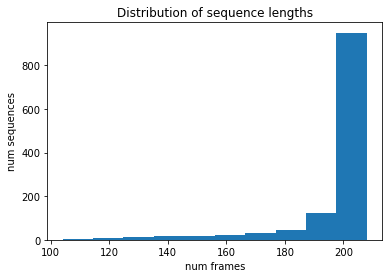

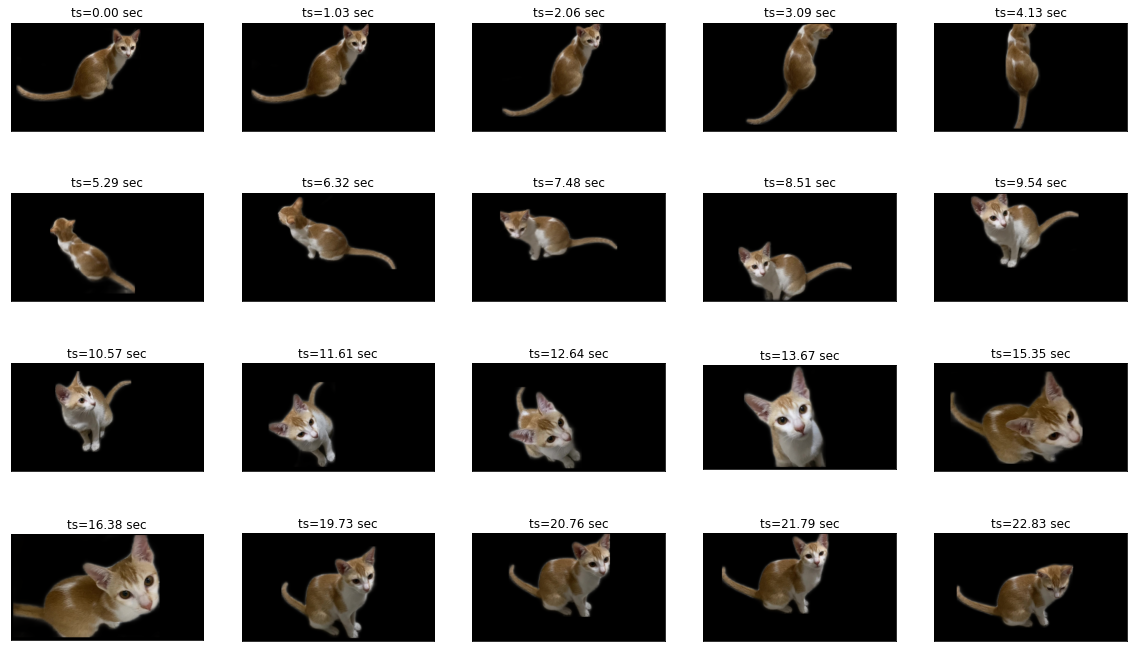

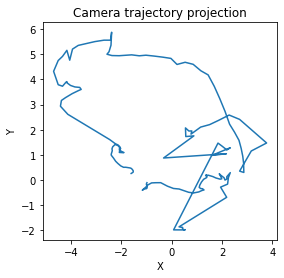

In [5]:
show_category("cat")

Number of sequences: 1825
Showing sequence 1006_114_680


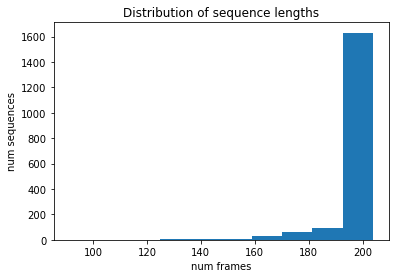

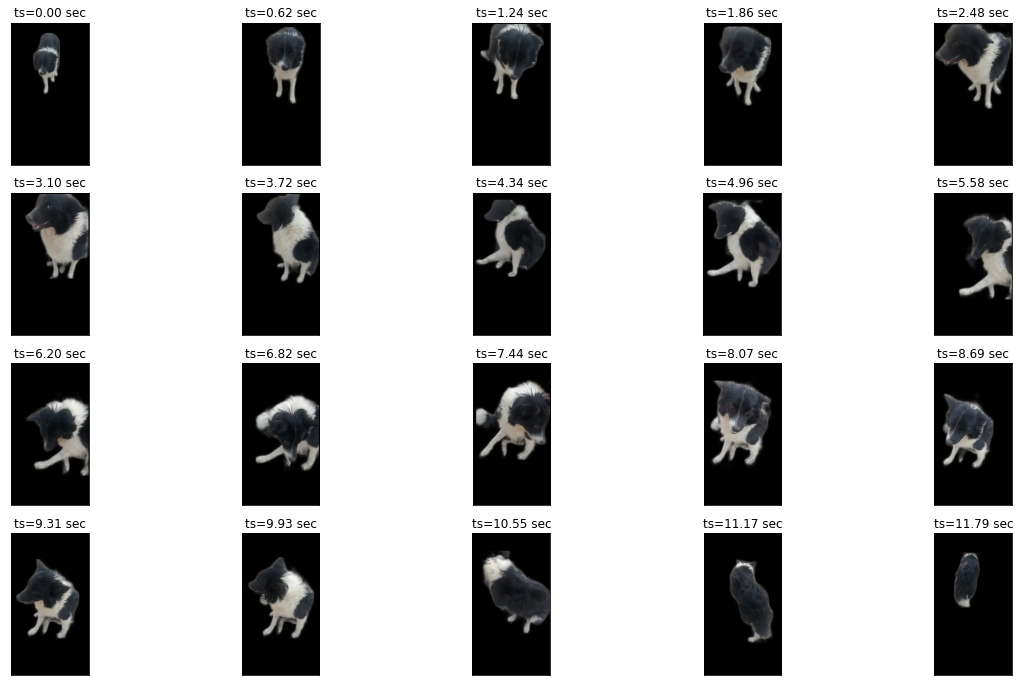

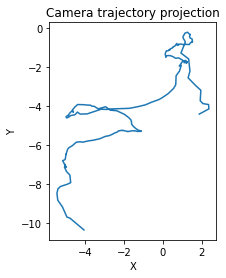

In [6]:
show_category("dog")